# Time Series Forecasting with the Long Short-Term Memory Network in Python

Original LInk is here: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ 


RNN has the promise of learning long sequences of observations. 
t seems a perfect match for time series forecasting, and in fact, it may be.

In this tutorial, you will discover how to develop an LSTM forecast model for a one-step univariate time series forecasting problem.

Goal of this tutorial:

1. How to develop a baseline of performance for a forecast problem
2. How to design a robust test harness for one-step time series forecasting
3. How to prepare data, develop, and evaluate an LSTM recurrent neural network for the time series forecasting

Tutorial overview:

1. Shampoo Sales Dataset
2. Test Setup
3. Persistence MOdel Forecast
4. LSTM Data Preparation
5. LSTM Model Development
6. LSTM Forecast
7. Complete LSTM Example
8. Develop a Robust Result
9. Tutorial Extensions

# 1 Shampoo Sales Dataset

In [1]:
# Digression of strptime investigation
# Syntax: time.strptime(string[, format])
# string − This is the time in string format which would be parsed based on the given format.
# format − This is the directive which would be used to parse the given string.


# Format specifies how the string should be parsed 
# %m stands for month while %M stands for minutes
# %d is day of the month

In [12]:
# Load and plot
from pandas import read_csv
from pandas import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


# Load dataset and writing the custom parser
def parser(x):
    return datetime.strptime(x, '%m/%d/%y')

# Man gotta figure out the strptime function to see how it actually works 

# Date_parser always get called to pass a function understand the dates
series=read_csv("/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv",header=0,parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)
series.head()


ValueError: time data '1-Jan' does not match format '%m/%d/%y'

In [ ]:
series

In [3]:
# Line plot
series.plot()
plt.xticks(rotation=90)
pyplot.show()
# The reason this chart doesn't match up with what's provided because python
# Understands time now and there are missing data for several points across multiple dates
# I guess I will have to try differently to reproduce this

NameError: name 'series' is not defined

In [4]:
filename="/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv"
def parser(x):
    return datetime.strptime('190'+x, '%Y-%b') # String manpuation
series=read_csv(filename, header=0,parse_dates=[0],index_col=0,squeeze=True)

# If the parsed data only contains one column then return a Series


In [5]:
labels=pd.date_range(start="1901-1-1",periods=len(series),freq="MS")
# Man this frequency is tricky. If just say M, it means month end.....
labels
series.index=labels

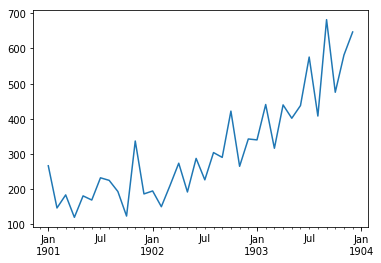

In [6]:
series.plot()
pyplot.show()
# Now this fully replicates what this guy has

# 2 Experimental Test Setup

1. Spliting the dataset into two parts: one training and one test
2. The first two years of data will be taken for the training dataset and the remaining one year of data will be for test set

In [53]:
X=series.values
train,test=X[0:-12],X[-12:]

#### Import things about how the model is to be trained
A rolling forecast scenario will be used. It is also called the walk forward model validation. Each time step of the test dataset will be walked one aat a time. A model will be used to make a forecast for the time step. Then the actual expected value from the test set will be taken and made available to the next time step

This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month.

Finally, all forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The RMSE is used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

#### Test code
from sklearn.metrics import mean_squared_error


import numpy as np


rmse=np.sqrt(mean_squared_error(test,predictions))


print("RMSE: %.3f" %rmse) # This really mimics the way in SAS how RMSE is handled

# 3 Persistence Model Forecast 
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast. 

The persistence forecast is where the observation from the prior time step is used to predict the observation at the current time step

This can be implemented by taking the last observation from the training data and histroy accumulated by walk forward validation and use that to predict the current time step

We can accumulate all predictions in an array so that they can be directly compared to the test dataset

In [11]:
# Contiue from the above
# Walk forward validation
history = [ x for x in train]
predictions=list()
for i in range(len(test)):
    #make prediction
    predictions.append(history[-1])
    # Observation
    history.append(test[i])
# report performance
rmse=np.sqrt(mean_squared_error(test,predictions))
print("RMSE: %.3f" % rmse)
#plotting this out
plt.plot(test)
plt.plot(predictions)
plt.show()
# This is simply the result of shifting the curve forward by 1 period

NameError: name 'np' is not defined

# 4 LSTM Data Preparation
Before actually fitting the LSTM model to the dataset, we need to transform the data.

Here there are 3 things that need to be taken care of:

1. Transform the time series into a supervised learning problem
2. Transform the time series data so that it is stationary
3. Transform the observations to have a specific scale

### Transforming time series into a supervised learning problem 

The LSTM model in Keras assumes that the data is divided into input(X) and output(y)

For the time series problem, this can be achieved by using the observation from the alst time step as input and the observation at the curretn time step as the output. 

We can achive this through using the shift() function in pandas. we would shift the time series by 1 place then the current time series as it stands is the output. 

We can then concatenate the two series together to create DF for supervised learning. The pushed down series will have a new position at the top with no value. A Nan value will be used here. We can use 0 to replace Nan. The LSTM model then has to learn as the start of the series as a month with zero sales on this dataset has not been observed. 

In [13]:
pd.DataFrame(X).shift(1)[:10]
# So shift basically takes the input array and shift them down by specified
# number of rows in the table

,0
0,NaN
1,266.0
2,145.9
3,183.1
4,119.3
5,180.3
6,168.5
7,231.8
8,224.5
9,192.8


In [14]:
# Helper function that takes numpy array of the raw time series and a lag or number of shifted series to create 
# and use as inputs
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)] # depends on how many lags are required
    columns.append(df) # Appending list to each other 
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True) #takes care of the Nan value
    return df

In [15]:
# Testing the function with Shampoo dataset and convert this into a supervised learning problem
from pandas import read_csv
from pandas import datetime
from pandas import concat

supervised=timeseries_to_supervised(X,1)
supervised.head()

,0,0
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3


### Transform Time Series to Stationary

The time series sales dataset isn't stationary. There's a structure in the data that's dependent on time. In fact there's an increasing trend in the data. 

Stationary data is easier to model and will very likely result in more skillful forecasts. 

The trend can be removed from observations, then added back to forecasts later to return the prediction to the original scale and calculate a comprable error score. 

A standard way to remove a trend is by differencing the data. That is the observation from previous time step (t-1) is substracted from the current observation (t). This removes the trend and we are left with a different series, or the changes to the observations from one time step to the next. 

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get more finer grained control and create our own function to compute the differences. 

Custom difference function:

In [16]:
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval, len(dataset)):
        value=dataset[i]-dataset[i-interval] # calcualting row vs row(-1) differnce
        diff.append(value)
    return pd.Series(diff)

# Not sure what this differencing does as of right now

This process also needs to be inverted in order to take forecasts made on the differenced series back into the original scale. 

In [17]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

### Testing out these two functions

In [18]:
# Transform the dataset to make it stationary
differenced=difference(series,1)
print(differenced.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64


In [19]:
# Invert transform
inverted=list()
for i in range(len(differenced)):
    value=inverse_difference(series, differenced[i],len(series)-i)
    inverted.append(value)
inverted=pd.Series(inverted)  
print(inverted.head())

0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


# Transform Time series to Scale

LSTMs expect data to be within the scale of the activation function used by the network. 

The default activation function for LSTMs is the hyperbolic tangent which outputs value between -1 and 1. This is the prefererred range for the time series data. 

To make the experiment fair, the scaling coefficients values must be calculated on the training dataset and applied to scale the terst dataset and any forecasts . This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1,1] using the minmixscaler class. This is a scikit learn transform classes. It requires provided in a matrix format with rows and columns. We need to reshape the numpy arrays before transforming. 

In [61]:
X=series.values
X

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3,
        339.7,  440.4,  315.9,  439.3,  401.3,  437.4,  575.5,  407.6,
        682. ,  475.3,  581.3,  646.9])

In [62]:
X=X.reshape(len(X),1) #Reshaping the input arrays into 1 by len(x) matrix
X

array([[ 266. ],
       [ 145.9],
       [ 183.1],
       [ 119.3],
       [ 180.3],
       [ 168.5],
       [ 231.8],
       [ 224.5],
       [ 192.8],
       [ 122.9],
       [ 336.5],
       [ 185.9],
       [ 194.3],
       [ 149.5],
       [ 210.1],
       [ 273.3],
       [ 191.4],
       [ 287. ],
       [ 226. ],
       [ 303.6],
       [ 289.9],
       [ 421.6],
       [ 264.5],
       [ 342.3],
       [ 339.7],
       [ 440.4],
       [ 315.9],
       [ 439.3],
       [ 401.3],
       [ 437.4],
       [ 575.5],
       [ 407.6],
       [ 682. ],
       [ 475.3],
       [ 581.3],
       [ 646.9]])

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1)) # Again storing it as a variable
scaler

# A note about the MinMaxScaler: it transforms features by scaling each feature 
# to a given range. The estimator scales and tanslates each feature individually such that it is 
# in the given range of the traninig set

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [64]:
scaler=scaler.fit(X) # What does this fit do?
scaler

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [65]:
scaled_X=scaler.transform(X) #Damn what's the difference between transform and scaler?
scaled_X[:10]

array([[-0.47858539],
       [-0.90545584],
       [-0.77323618],
       [-1.        ],
       [-0.7831882 ],
       [-0.82512884],
       [-0.60014217],
       [-0.6260885 ],
       [-0.73875955],
       [-0.98720455]])

In [66]:
# Invert transform
inverted_X=scaler.inverse_transform(scaled_X)
inverted_X[:10] # Fitting this first and then transforom this back 

array([[ 266. ],
       [ 145.9],
       [ 183.1],
       [ 119.3],
       [ 180.3],
       [ 168.5],
       [ 231.8],
       [ 224.5],
       [ 192.8],
       [ 122.9]])

# LSTM MOdel Development

The data for the LSTM network is done and we can start developing the model.

A benefit of this type of network is that it can learn and remember over long sequences and does not reply on pre-specified window lagged observation as input. 

In Keras, this is referred to as stateful, and involves setting the stateful argument True when defining an LSTM layer. 

By default, an LSTM layer in keras maintains state between data within one batch. A batch of data is a fixed sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions [samples, time steps, features] 
1. Samples: These are independent observations from the domain, typically rows of data
2. Time Steps: these are separate time steps of a given variable for a given observation
3. These are separate measures observed at the time of observation 

Given that the training set is defined as X inputs and y outputs, the dataset must be reshaped into (Samples, timesteps, features 


In [51]:
train

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3])

In [67]:
X,y=train[0:-1], train[-1]
X

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5])

In [56]:
y

342.30000000000001

In [58]:
X.shape[0]

23

In [60]:
X.shape

(23,)

In [57]:
# This is the code to be used a as a part of the function
# X=X.reshape(X.shape[0],1,X.shape[1])

IndexError: tuple index out of range

The shape of the input data must be specified in the LSTM layer using the batch input shape argument as a tuple that specifies the expected number of observations to read each batch, the number of time stpes and the number of features.

The batch size is often much smaller than the total number of samples. The batch size along with the number of epochs defines how quickly the network learns the data (how often the weights are updated). 

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient. 

The following code creates a single LSTM hidden layer that also specifies the expectations of the input layer via the batch_input_shape arguemtn.

In [68]:
# layer=LSTM(neurons, batch_input_shape=(batch_size, X.shape[1],X.shape[2]),stateful=True)


The network requires a single neuron in the output layer with a linear activation to predict the number of shampoo sales at the next time step. 

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano. 

In compiling the network, we must specify a loss function and optimization algorithm. We can use the mean_squared_error as the loss function as it closely matches RMSE and the efficient ADAM optimization algorithm. 

Using the sequential Keras API to define the network. Keras' framework in defining / compiling the network. 

In [71]:

#What does the sequential thing do? Is it the same practice of 
#calling the model first?
'''
model=Sequential()
model.add(layer=LSTM(neurons, batch_input_shape=(batch_size, X.shape[1],X.shape[2]),stateful=True))
model.add(Dense(1)) #Is this defining the memory units 
model.compile(loss="mean_squared_error",optimizer='adam')

#What's adam? what's Dense? What's batch_input_shape?
'''


'\nmodel=Sequential()\nmodel.add(layer=LSTM(neurons, batch_input_shape=(batch_size, X.shape[1],X.shape[2]),stateful=True))\nmodel.add(Dense(1)) #Is this defining the memory units \nmodel.compile(loss="mean_squared_error",optimizer=\'adam\')\n\n#What\'s adam? what\'s Dense? What\'s batch_input_shape?\n'

Once Compiled, it can be fit to the training data. Because the network is stateful, we need to control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs. 

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting shuffle to false. 

Also by default, the network reports a lot of debug information about the learning progress and the skill of the model at the end of each epoch. We can disable this by setting the verbose argument to the level of 0. Verbose controls the level report required. 

We can then reset the internal state at the end of the training epoch, ready for the next training iteration. 

In [73]:
'''
for i in range(nb_epoch):
    model.fit(X,y,epochs=1,batch_size=batch_size,verbose=0,shuffle=False)
    model.reset_states()
 '''   

'\nfor i in range(nb_epoch):\n    model.fit(X,y,epochs=1,batch_size=batch_size,verbose=0,shuffle=False)\n    model.reset_states()\n '

Putting all the above together, we have the function called fit_lstm() that trains and returns a LSTM model. As arguments, it takes the following:
1. training dataset in a supervised learning format
2. A batch size
3. A number of epochs
4. A number of neurons



In [74]:
def fit_lstm(train,batch_size,nb_epoch,neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #define the loss function and optimization algorithm here
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets.

The predict() function on the model is also constrained by the batch size;there it must be set to 1 because we are interested in making one step forecasts on the test data. 

Fit LSTM model to make a one step forecast

# LSTM forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts. 

There are some flexibility in how the model should be trained:
1. Fit the model once on all training data then predict each new time step one at a time from the test data ( this is the fixed approach)
2. Re fit the model or update the model each time step of the test data as new observations from the test data s new observations from the test data are made available (dynamic approach)

Dynamic would have a better model skill. 

To make the forecast, we can use the predict() function on the model. This requires a 3D Numpy array input as an argument. 

The predict() function returns an array of predictions, one for each input row provided. 

Wd can capture this behavior through the function named forecast(). Given a fit model, a batch size used when fitting the model and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value

In [75]:
def forecast(model, batch_size,row):
    X=row[0:-1]
    X=X.reshape(1,1,len(x))
    yhat=model.predict(X,batch_size=batch_size)
    return yhat[0,0]

During training, the internal state is reset after each epoch. While forecasting, we will not want to reset the internal state between forecasts. In fact, we would like the model to build up state as we forecast each time step in the test dataset.

This raises the question as to what would be a good initial state for the network prior to forecasting the test dataset.

In this tutorial, we will seed the state by making a prediction on all samples in the training dataset. In theory, the internal state should be set up ready to forecast the next time step.

We now have all of the pieces to fit an LSTM Network model for the Shampoo Sales dataset and evaluate its performance.

In the next section, we will put all of these pieces together.

# Complete LSTM end to end

Things to do:
1. Load the dataset
2. Transform the data set to make it suitable for the LSTM:
    1. Transforming the data to a supervised learning problem
    2. Transforming the data to be stationary
    3. Transforming the data so that it has the scale -1 to 1
3. Fitting a stateful LSTM network model to the training data
4. Evaluating the static LSTM model on the test data
5. Report the performance of the forecasts 

NOt sure what the stateful parameters are for here

Notes about doing this end to end:
1. Scaling and inverse scaling behaviors have moved to the functions cale() and invert_scale()
2. Test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
3. The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled
4. Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. 

All the following involves putting custom stuff into functions

In [80]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

filename="/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv"
# datetime parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%b') # String manpuation

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data,lag=1):
    df=DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)]
    columns.append(df)
    df=concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df

# create a differenced series
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval, len(dataset)):
        value=dataset[i]-dataset[i-interval]
        diff.append(value)
    return Series(diff)



In [86]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat+history[-interval]

# scale train and test data to [-1,1]
def scale(train,test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler=scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0],train.shape[1])
    train_scaled=scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0],test.shape[1])
    test_scaled=scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler,X,value):
    new_row=[x for x in X] +[value]
    array=numpy.array(new_row)
    array=array.reshape(1,len(array))
    inverted=scaler.inverse_transform(array)
    return inverted[0,-1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X,y=train[:,0:-1],train[:,-1]
    X=X.reshape(X.shape[0],1,X.shape[1])
    model=Sequential()
    model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error",optimizer="adam")
    for i in range(nb_epoch):
        model.fit(X,y,epochs=1,batch_size=batch_size,verbose=0,shuffle=False)
        model.reset_states()
    return model



In [87]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X=X.reshape(1,1,len(X))
    yhat=model.predict(X,batch_size=batch_size)
    return yhat[0,0]

# load the dataset
series=read_csv(filename, header=0,parse_dates=[0],index_col=0,squeeze=True)

# transform data to be staionary
raw_values=series.values
diff_values=difference(raw_values,1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values,1)
supervised_values=supervised.values

# split data into train and test-sets
train,test=supervised_values[0:-12],supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)



In [88]:
# fit the model
lstm_model=fit_lstm(train_scaled,1,3000,4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped=train_scaled[:,0].reshape(len(train_scaled),1,1)
lstm_model.predict(train_reshaped,batch_size=1)


array([[-0.73125315],
       [-0.00820051],
       [-0.71663928],
       [ 0.13935299],
       [-0.33695614],
       [ 0.12812035],
       [-0.23958614],
       [ 0.04869419],
       [ 0.15605216],
       [ 0.69230235],
       [-0.99738336],
       [-0.01098327],
       [-0.2058185 ],
       [ 0.332838  ],
       [-0.13686416],
       [-0.24350363],
       [ 0.28404182],
       [-0.44929284],
       [ 0.20990427],
       [-0.34694719],
       [ 0.0514022 ],
       [-0.96820319],
       [ 0.08347751]], dtype=float32)

Month=1, Predicted=227.474999, Expected=339.700000
Month=2, Predicted=276.631472, Expected=440.400000
Month=3, Predicted=252.944398, Expected=315.900000
Month=4, Predicted=339.566582, Expected=439.300000
Month=5, Predicted=293.259686, Expected=401.300000
Month=6, Predicted=389.261160, Expected=437.400000
Month=7, Predicted=403.032822, Expected=575.500000
Month=8, Predicted=365.462083, Expected=407.600000
Month=9, Predicted=422.679146, Expected=682.000000
Month=10, Predicted=273.866968, Expected=475.300000
Month=11, Predicted=403.832973, Expected=581.300000
Month=12, Predicted=371.172818, Expected=646.900000
Test RMSE: 161.807


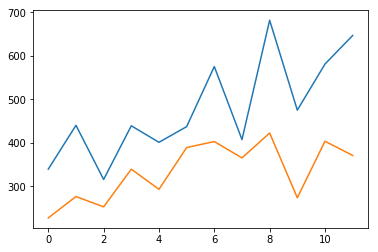

In [90]:
# walk forward validation on the test data
predictions=list()
for i in range(len(test_scaled)):
    # make one step forecast
    X,y=test_scaled[i,0:-1],test_scaled[i,-1]
    yhat=forecast_lstm(lstm_model,1,X)
    # invert scaling
    yhat=invert_scale(scaler,X,yhat)
    # invert differencing
    yhat=inverse_difference(raw_values,yhat,len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected=raw_values[len(train)+i+1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    
# report performance
rmse=sqrt(mean_squared_error(raw_values[-12:],predictions))
print("Test RMSE: %.3f" %rmse)

# line pot of observed vs predicted 
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Month=1, Predicted=243.716264, Expected=339.700000
Month=2, Predicted=325.051053, Expected=440.400000
Month=3, Predicted=309.221334, Expected=315.900000
Month=4, Predicted=365.034440, Expected=439.300000
Month=5, Predicted=284.260864, Expected=401.300000
Month=6, Predicted=390.386362, Expected=437.400000
Month=7, Predicted=372.479885, Expected=575.500000
Month=8, Predicted=396.481697, Expected=407.600000
Month=9, Predicted=432.322888, Expected=682.000000
Month=10, Predicted=378.471275, Expected=475.300000
Month=11, Predicted=428.956407, Expected=581.300000
Month=12, Predicted=378.928738, Expected=646.900000
Test RMSE: 144.931


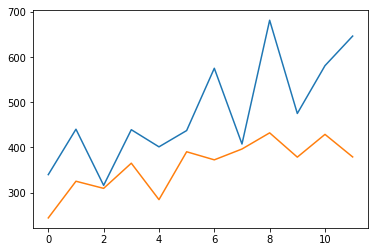

In [93]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
filename="/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv"
# datetime parsing function for loading the dataset
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%b')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series=read_csv(filename, header=0,parse_dates=[0],index_col=0,squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Seems like I couldn't replicate the prediction results from the tutorial. The LSTM output seems pathetically off as comparing to other more traditional methods. 

From the way the author claims, the reason this could be really off is because of random seeding involved. 

In [94]:
yhat=forecast_lstm(lstm_model,1,X)


In [96]:
yhat=y

In [97]:
y

0.20151065551659025

# Develop a robust Result 

A difficulty with neural networks is that they give different results with different starting conditions.

One approach could be to fix the random number seed used by Keras to ensure the results are reproducible.Another could be to control for the random initial conditions using a different setup

repeating the experiment from the previous section multiple times and take advantage of the fact that RMSE as an indication of how well the configuration would be expected to perform on unseen data on average. 

This is often call multiple repeaets or multiple restarts 

We can wrap the model fitt